In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import logging
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from darts import TimeSeries
from darts.models import NaiveMean, ExponentialSmoothing, LinearRegressionModel, Prophet
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, smape, rmse, mae
from darts.datasets import *

mpl.rcParams['figure.dpi'] = 300
logging.disable(logging.CRITICAL)

Importing plotly failed. Interactive plots will not work.


In [6]:
df = pd.read_csv('data/monthly_in_situ_co2_mlo.csv',
                 comment = '"', header = [0,1,2], na_values = '-99.99')

cols = [' '.join(col).replace(' ', '') for col in df.columns.values]
df.set_axis(cols, axis = 1, inplace = True)

# Converting Excel date format to datetime
# and setting as dataframe index
df['datetime'] = pd.to_datetime(df['DateExcel'], origin = '1899-12-31', unit = 'D')
#df['datetime'] = pd.to_datetime(df['Yr'].astype(str) + '-' + df['Mn'].astype(str),
df.set_index('datetime', inplace = True)

df = df[['CO2filled[ppm]']]
df.rename(columns = {'CO2filled[ppm]': 'values'}, inplace = True)
df.dropna(inplace = True)
df = df.resample('M').sum()

In [7]:
df

,values
datetime,
1958-03-31,315.70
1958-04-30,317.45
1958-05-31,317.51
1958-06-30,317.25
1958-07-31,315.86
...,...
2021-08-31,414.34
2021-09-30,412.90
2021-10-31,413.55


## Time Series Analysis
In this section, we are going to analyze the dataset so we can understand its basic statistical properties, something that can be accomplished by creating various types of visualizations.

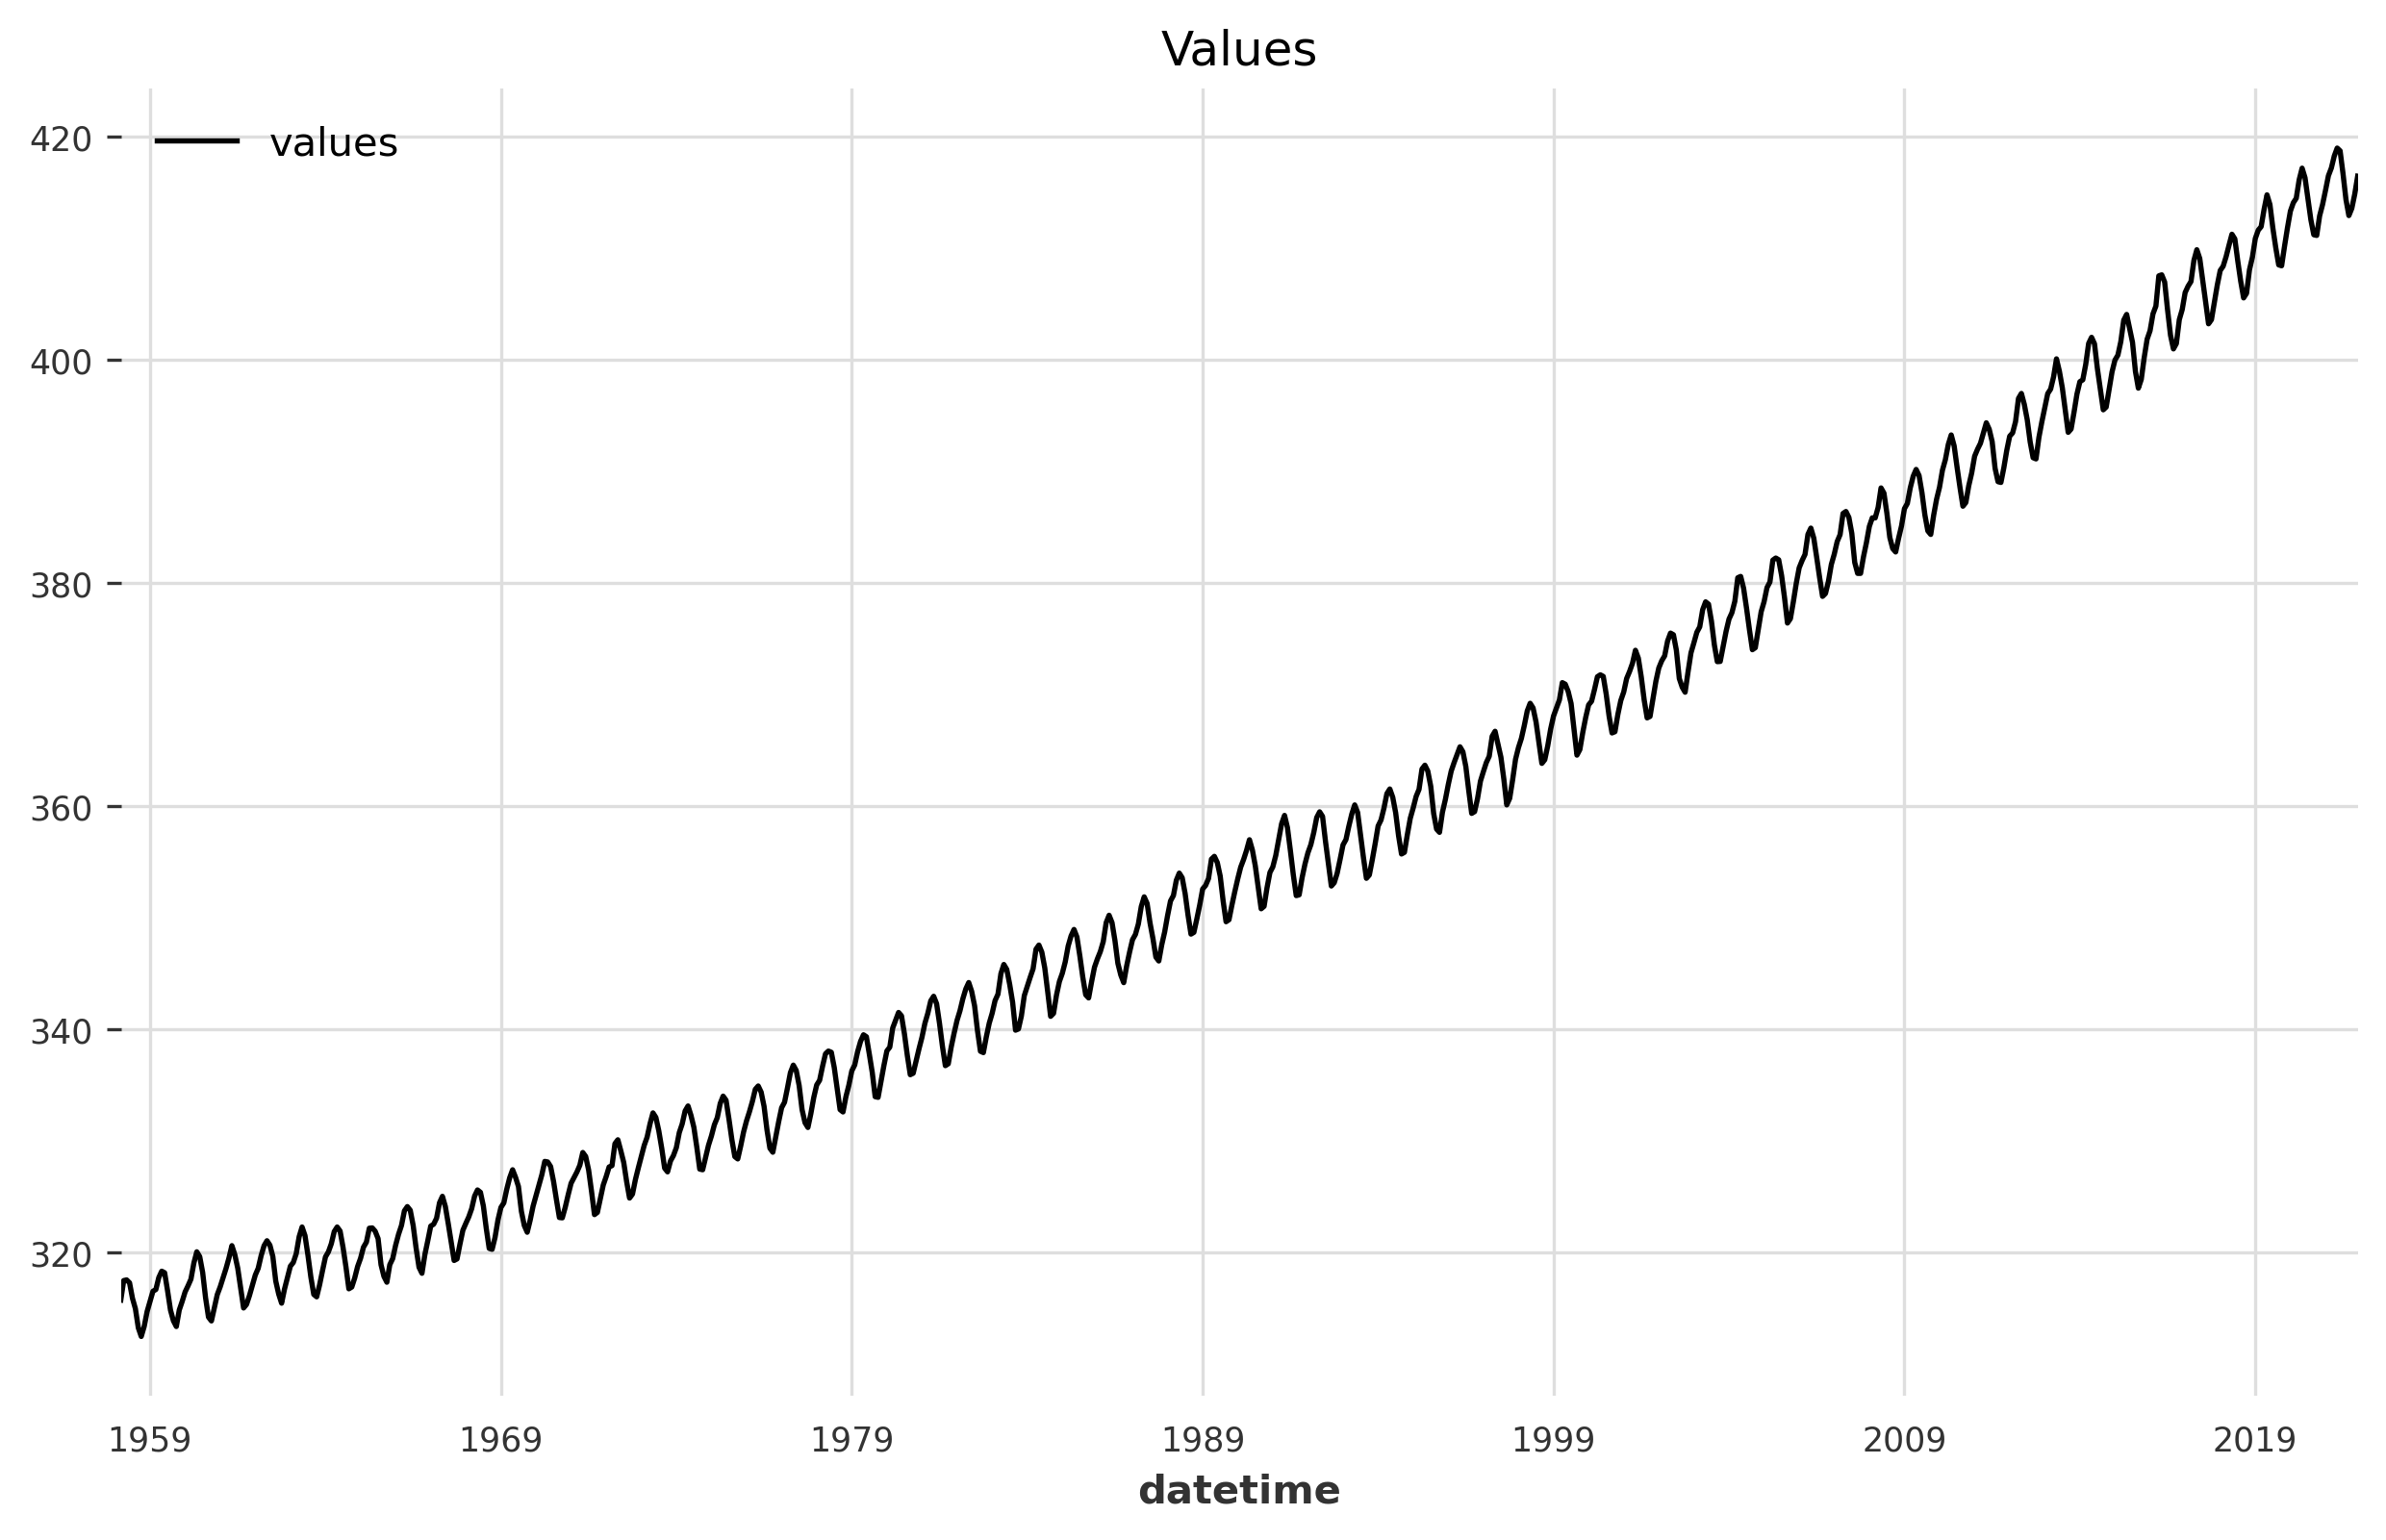

In [8]:
df.plot(figsize=(10,6))
plt.title('Values')

plt.show()

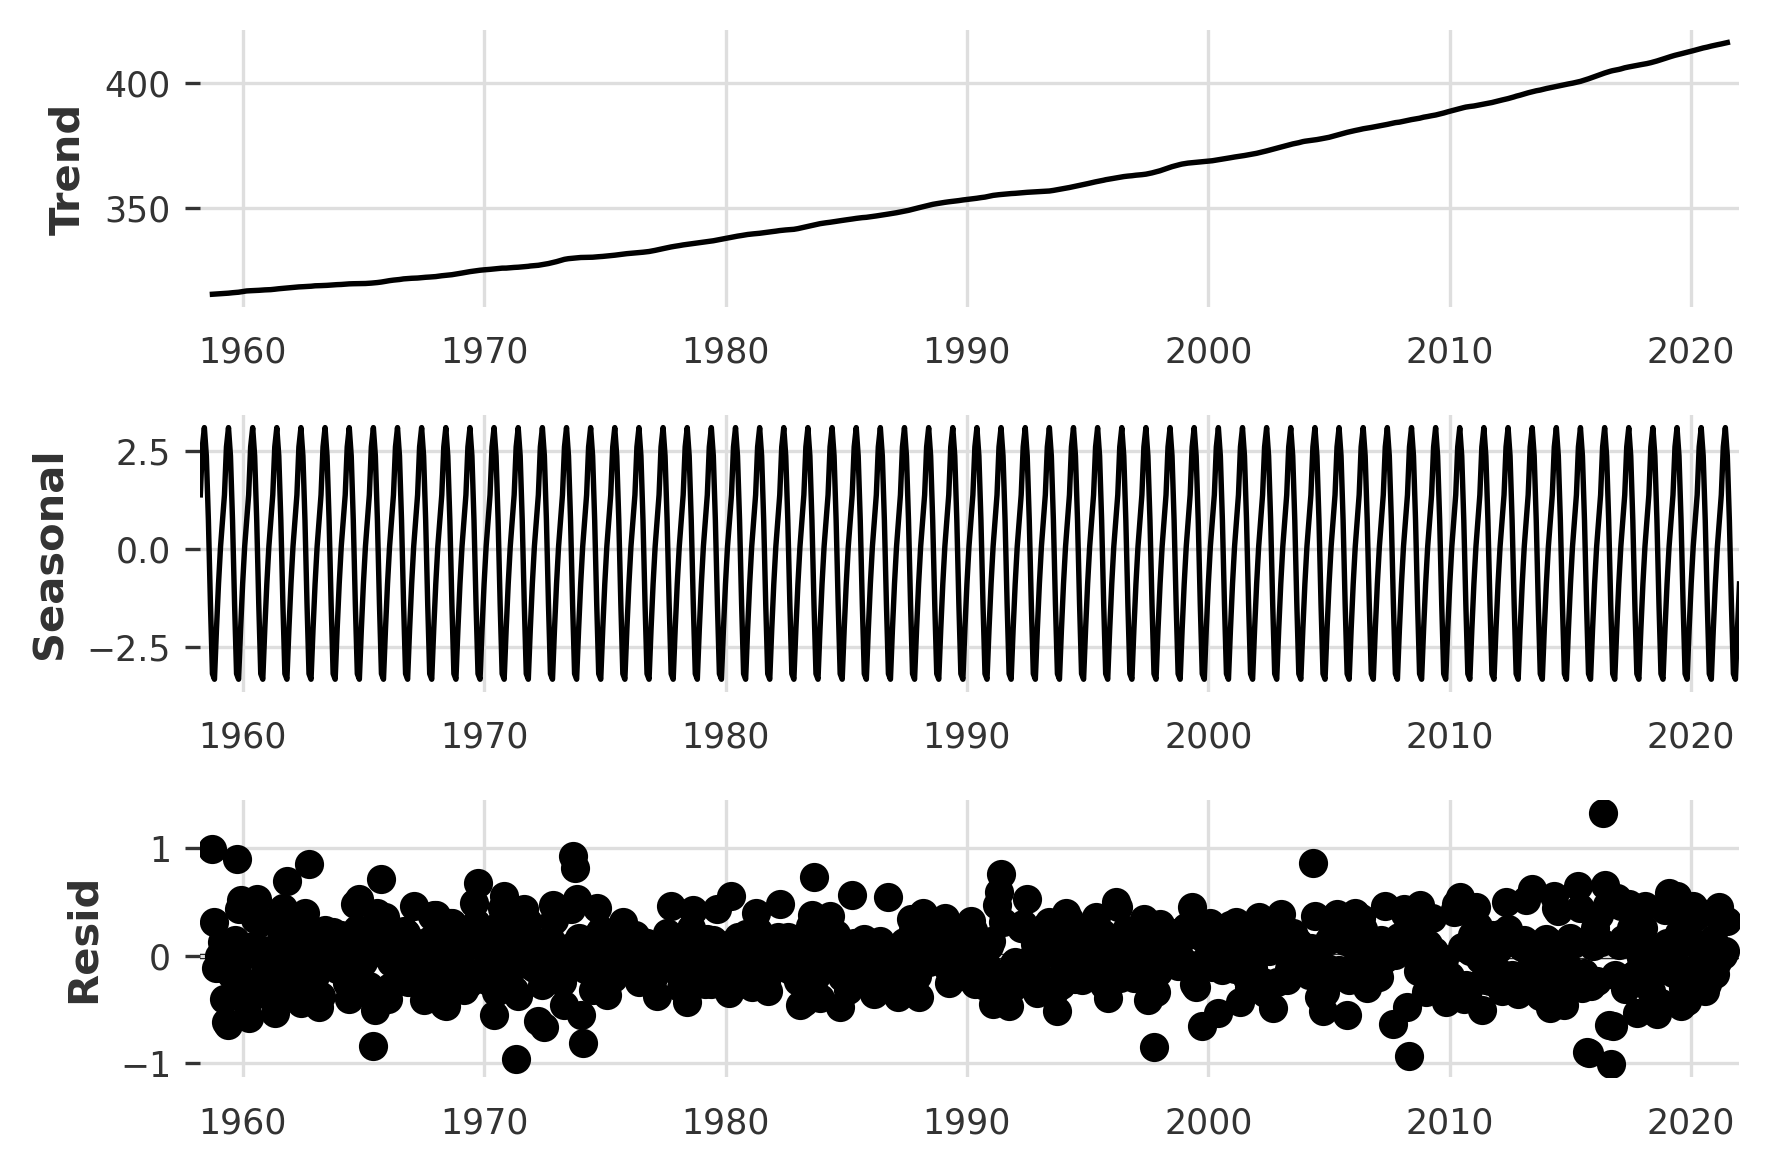

In [9]:
result = seasonal_decompose(df)
result.plot(observed = False)

plt.show()

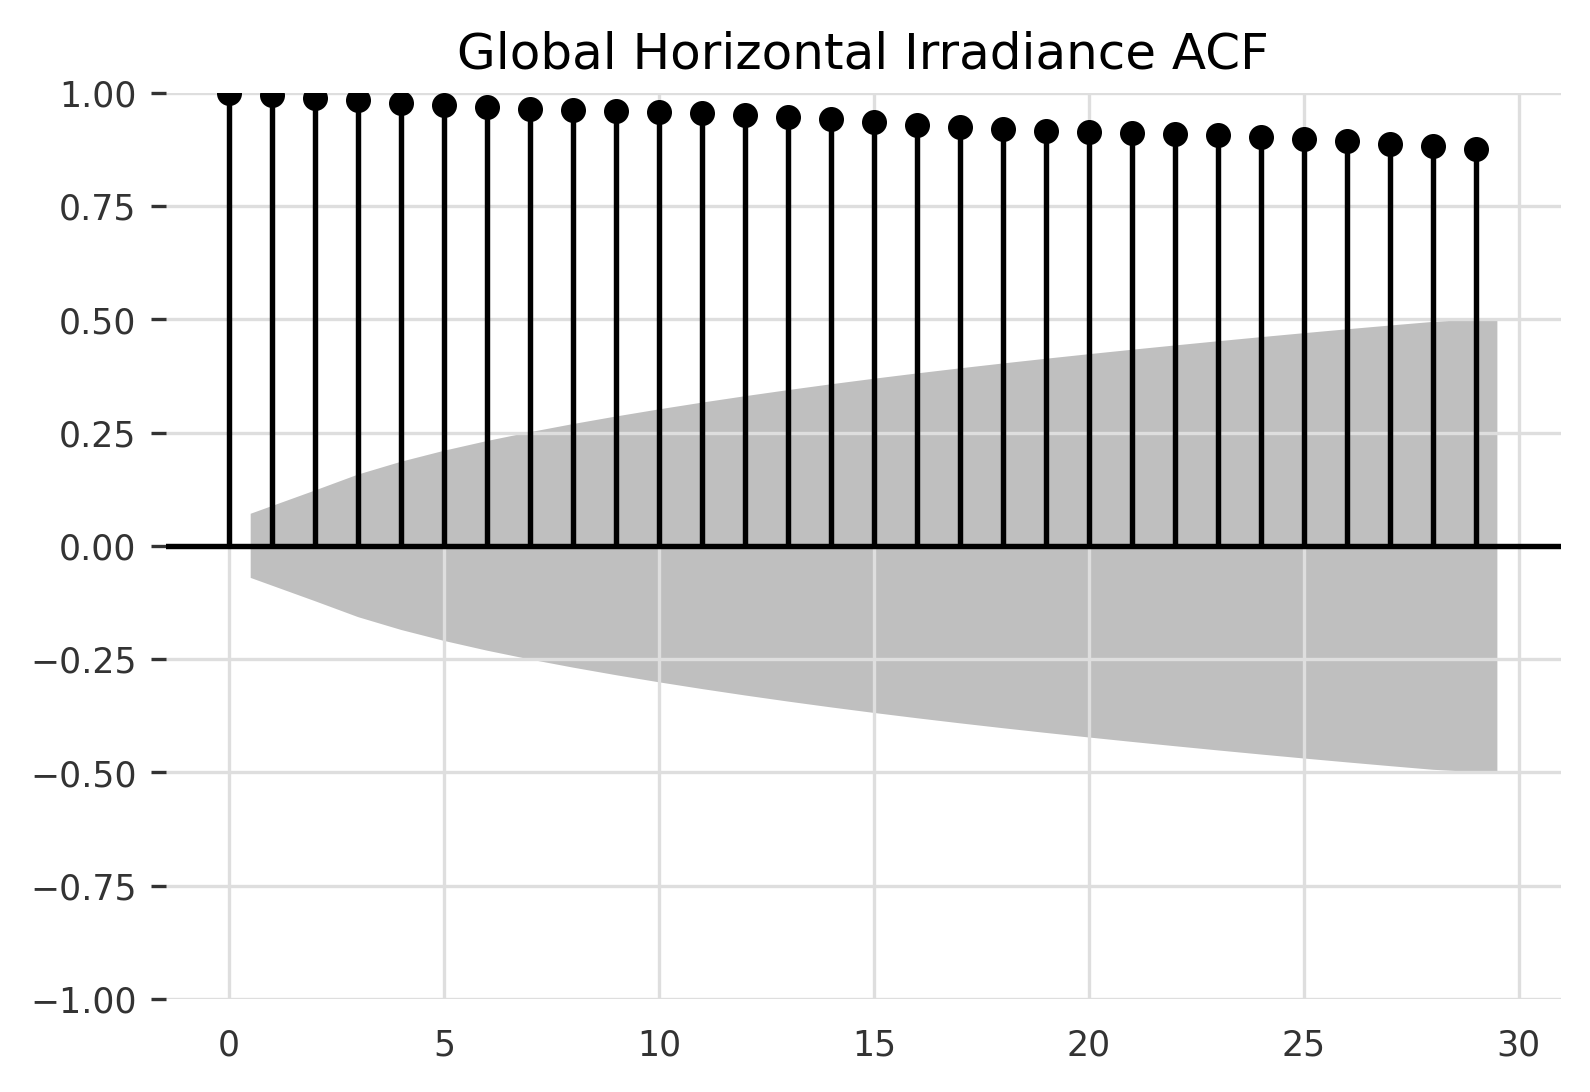

In [10]:
#fig, ax = plt.subplots(figsize = (10,6))

plot_acf(df, title = 'Global Horizontal Irradiance ACF')

plt.show()

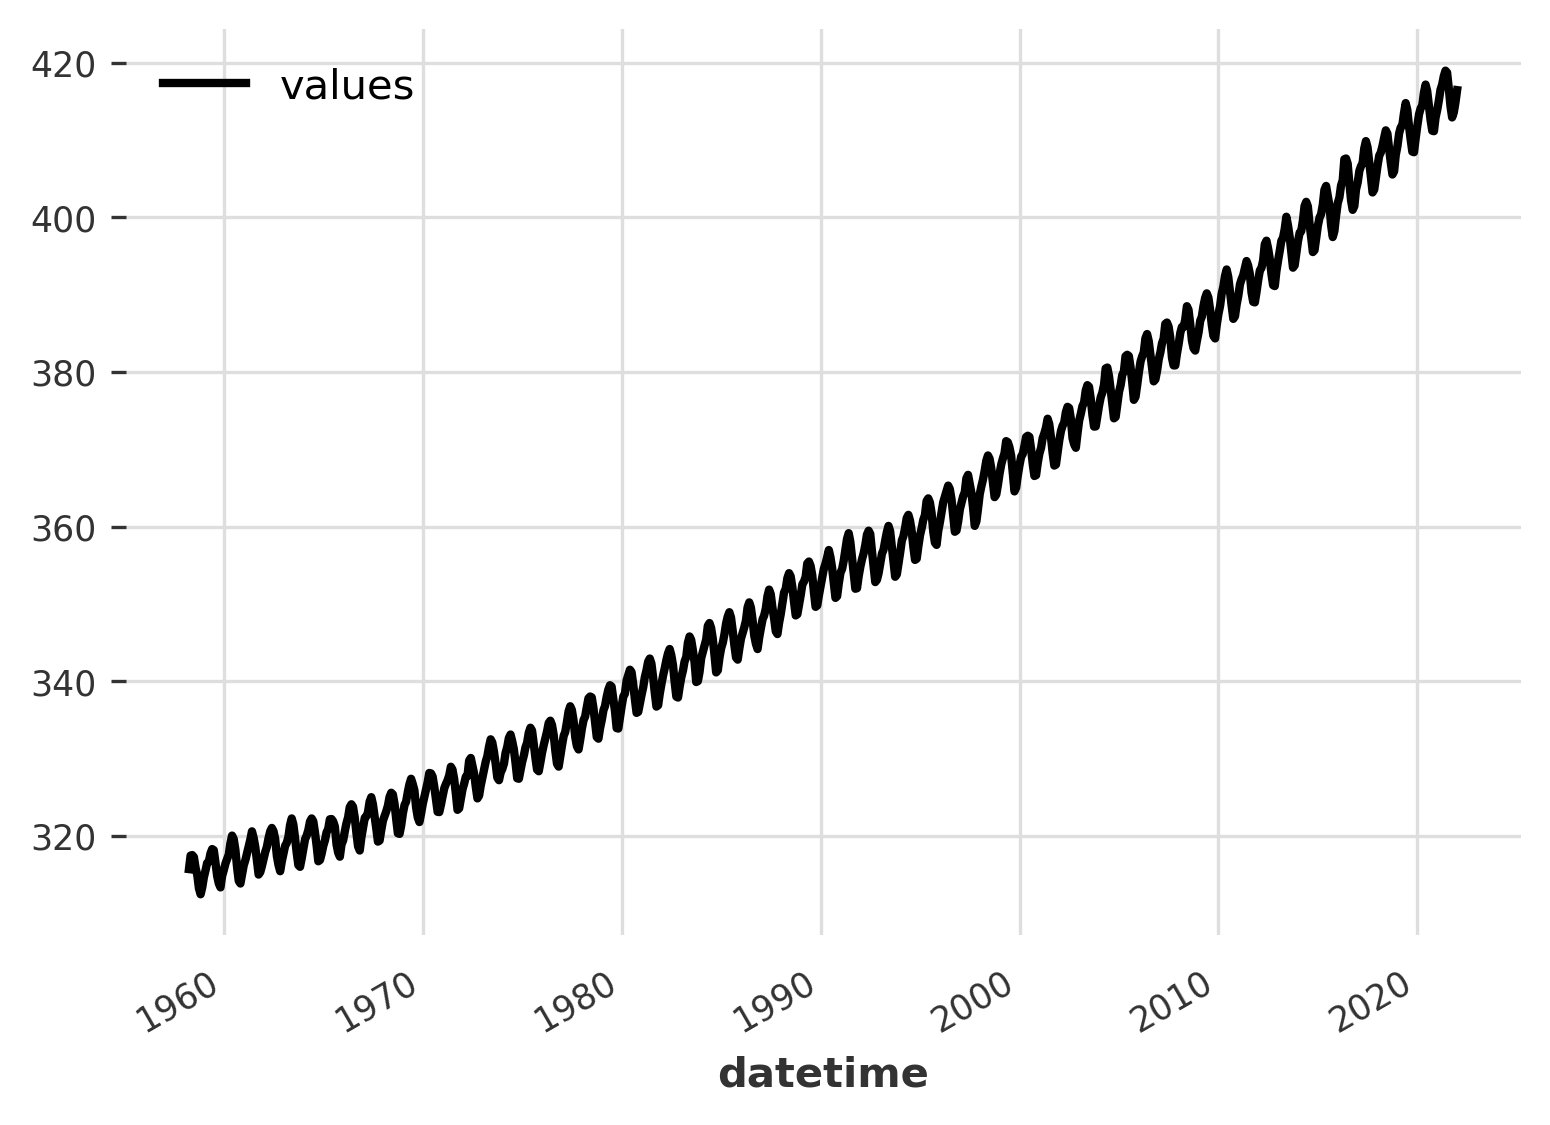

In [11]:
#Loading the pandas dataframe to a TimeSeries object
#As required by the Darts library
series = TimeSeries.from_dataframe(df)

series.plot()

### Creating Utility Functions

In [60]:
def backtest(series, model, start):
    
    historical_fcast = model.historical_forecasts(series, start=start, forecast_horizon=12,                                   
                                                  last_points_only = False, stride = 12,
                                                  verbose = True)
    df = pd.DataFrame()
    for item in historical_fcast:
        df = df.append(item.pd_dataframe())
        
    historical_fcast = TimeSeries.from_dataframe(df)
    return historical_fcast

def plot_backtest(series, forecast):
    idx = 0
    series[idx:].plot(label='Actual Values')
    forecast[idx:].plot(label= 'Forecast')
    plt.show()
    
def print_metrics(series, forecast):
    smape_ = smape(series, forecast)
    mae_ = mae(series, forecast)
    rmse_ = rmse(series, forecast)
    
    df = pd.DataFrame({'SMAPE': smape_, 'MAE': mae_, 'RMSE': rmse_}, index = [0])
    return(df.round(decimals = 2))       
    

We have created the `plot_backtest()` utility function to evaluate model accuracy. This will be accomplished by using the `backtest()` function that computes error scores between the forecasts the model would have produced with an expanding training window over series and the actual values.

### Creating a Naive Forecasting Model
We begin by setting a baseline accuracy with a naive forecasting model. This will help us evaluate the performance of more complex models, that theoretically should have higher accuracy than the baseline.

In [64]:
start = pd.Timestamp('123116')
#start = 0.80

  0%|          | 0/5 [00:00<?, ?it/s]

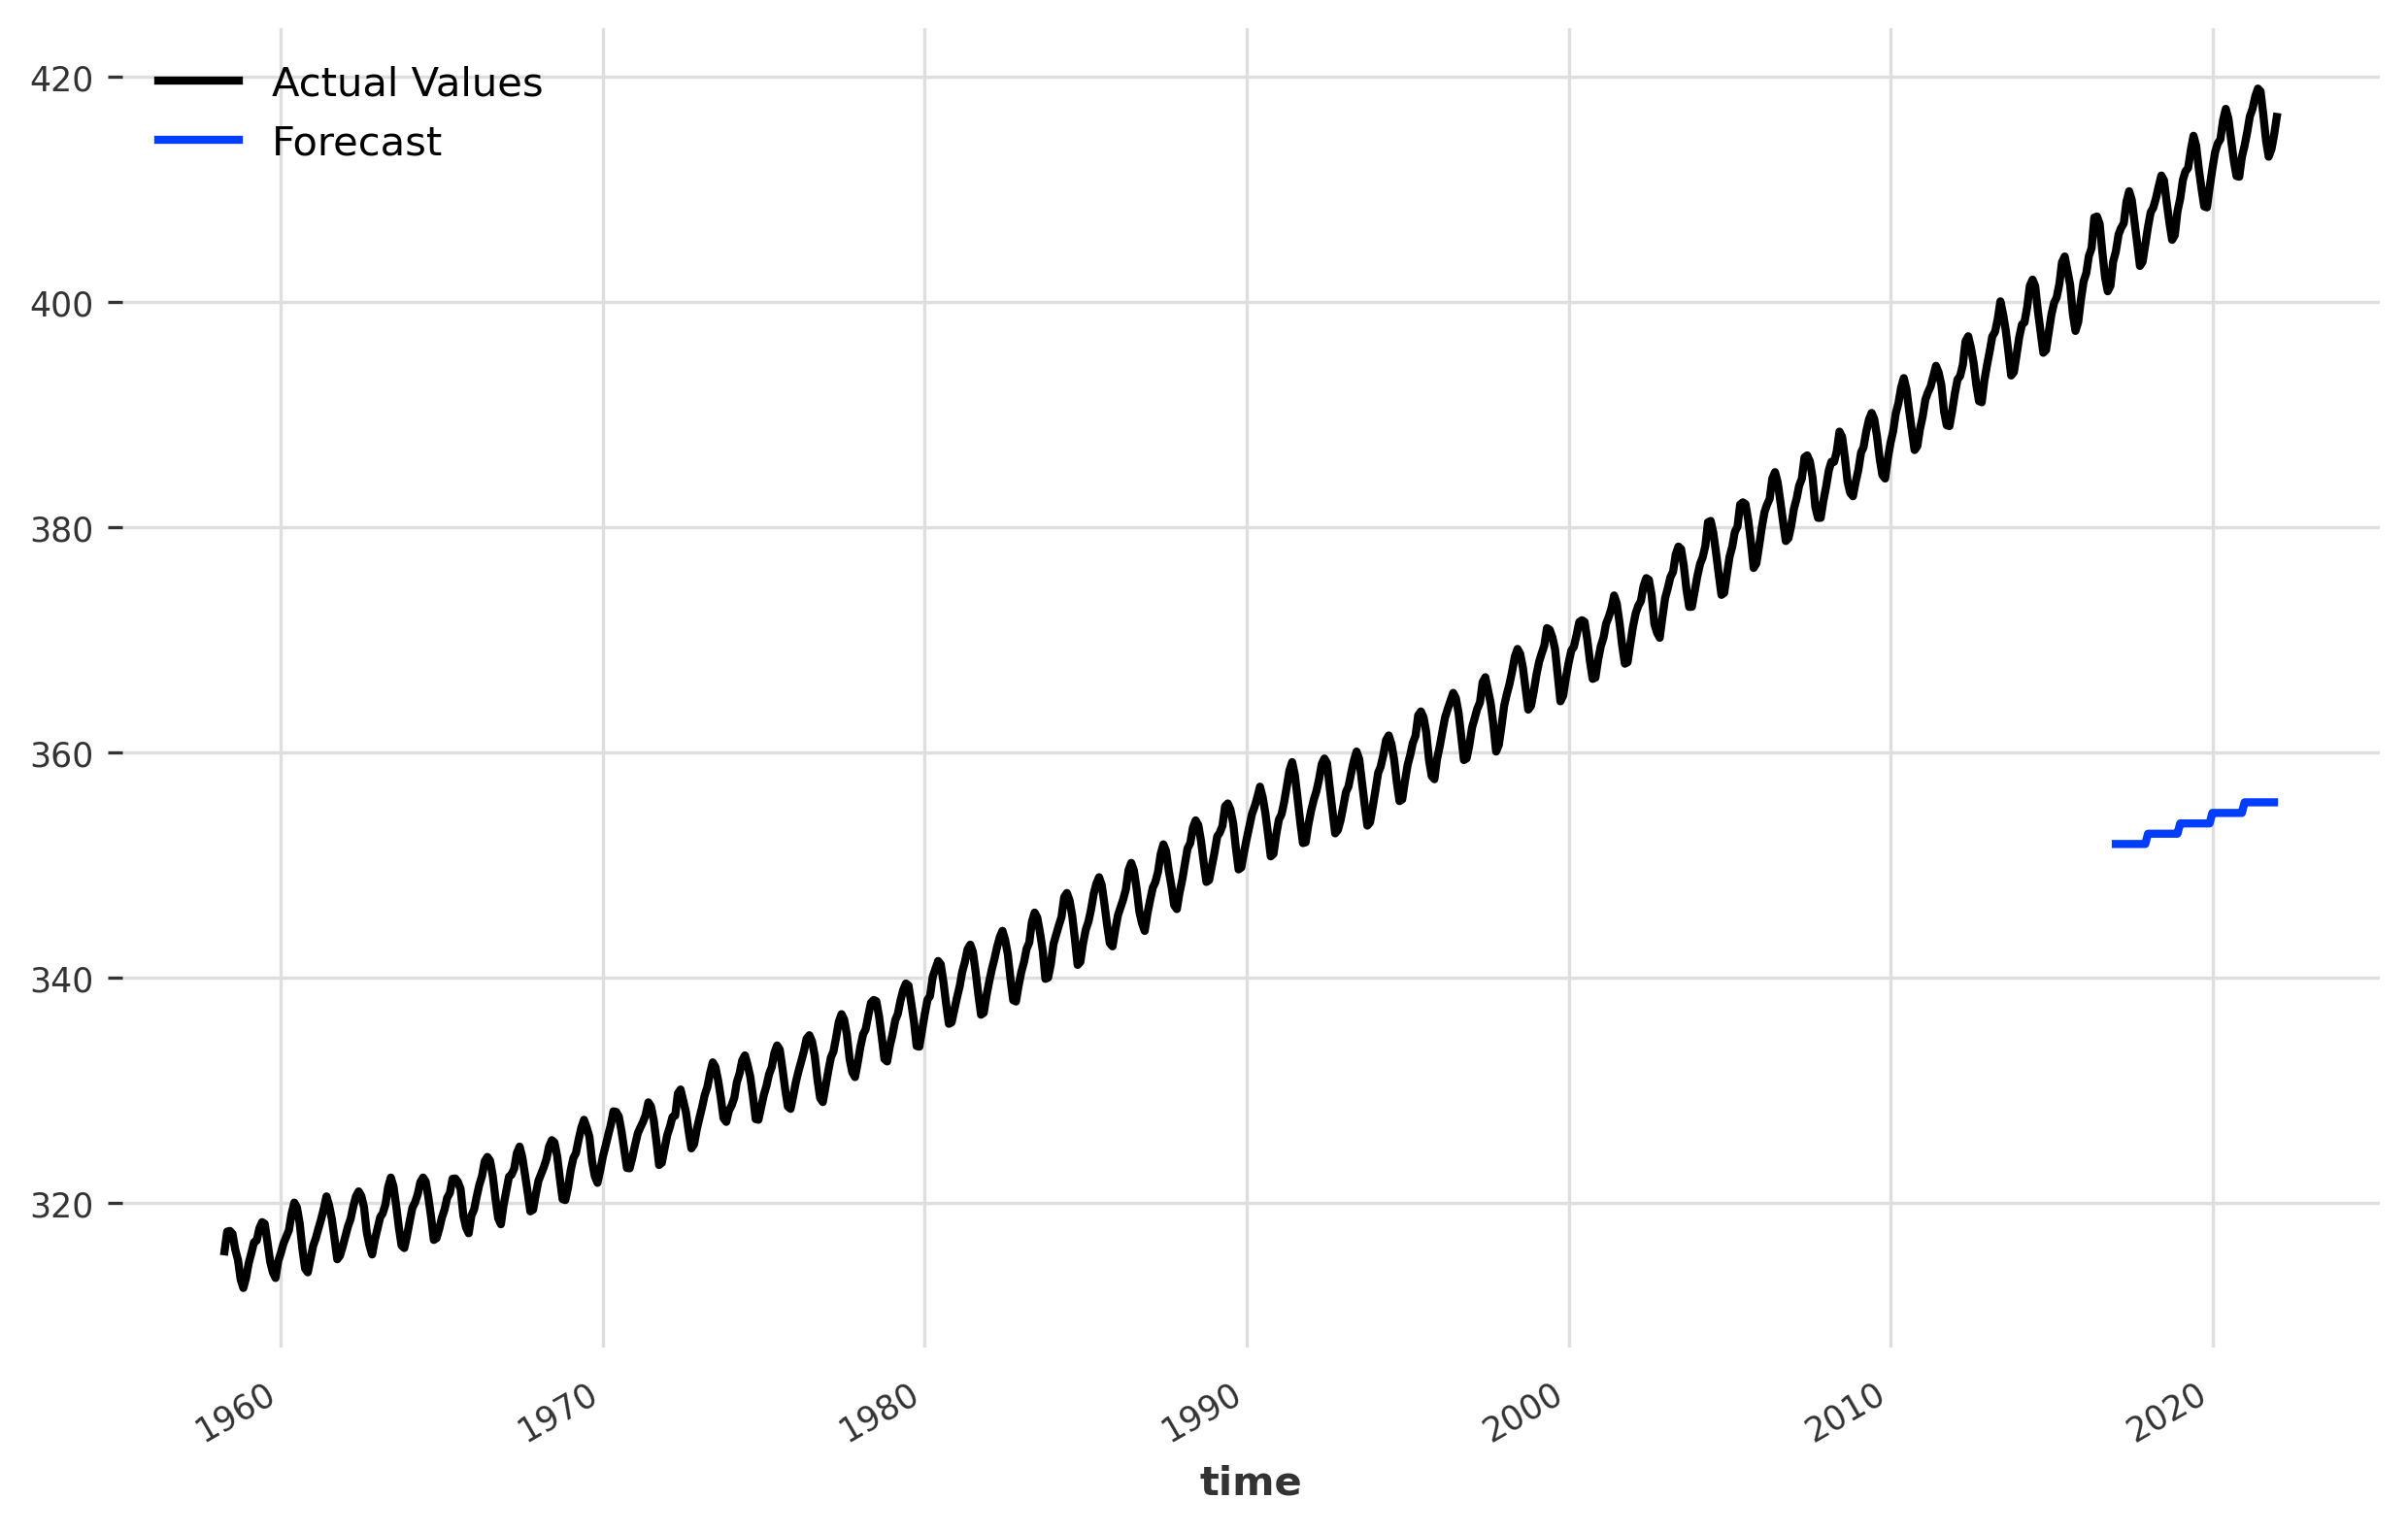

,SMAPE,MAE,RMSE
0,15.01,57.4,57.47


In [65]:
model = NaiveMean()

plt.figure(figsize = (10, 6))

forecast = backtest(series, model, start)
plot_backtest(series, forecast)
df = print_metrics(series, forecast)

plt.show()
df

### Creating an Exponential Smoothing Forecasting Model

  0%|          | 0/5 [00:00<?, ?it/s]

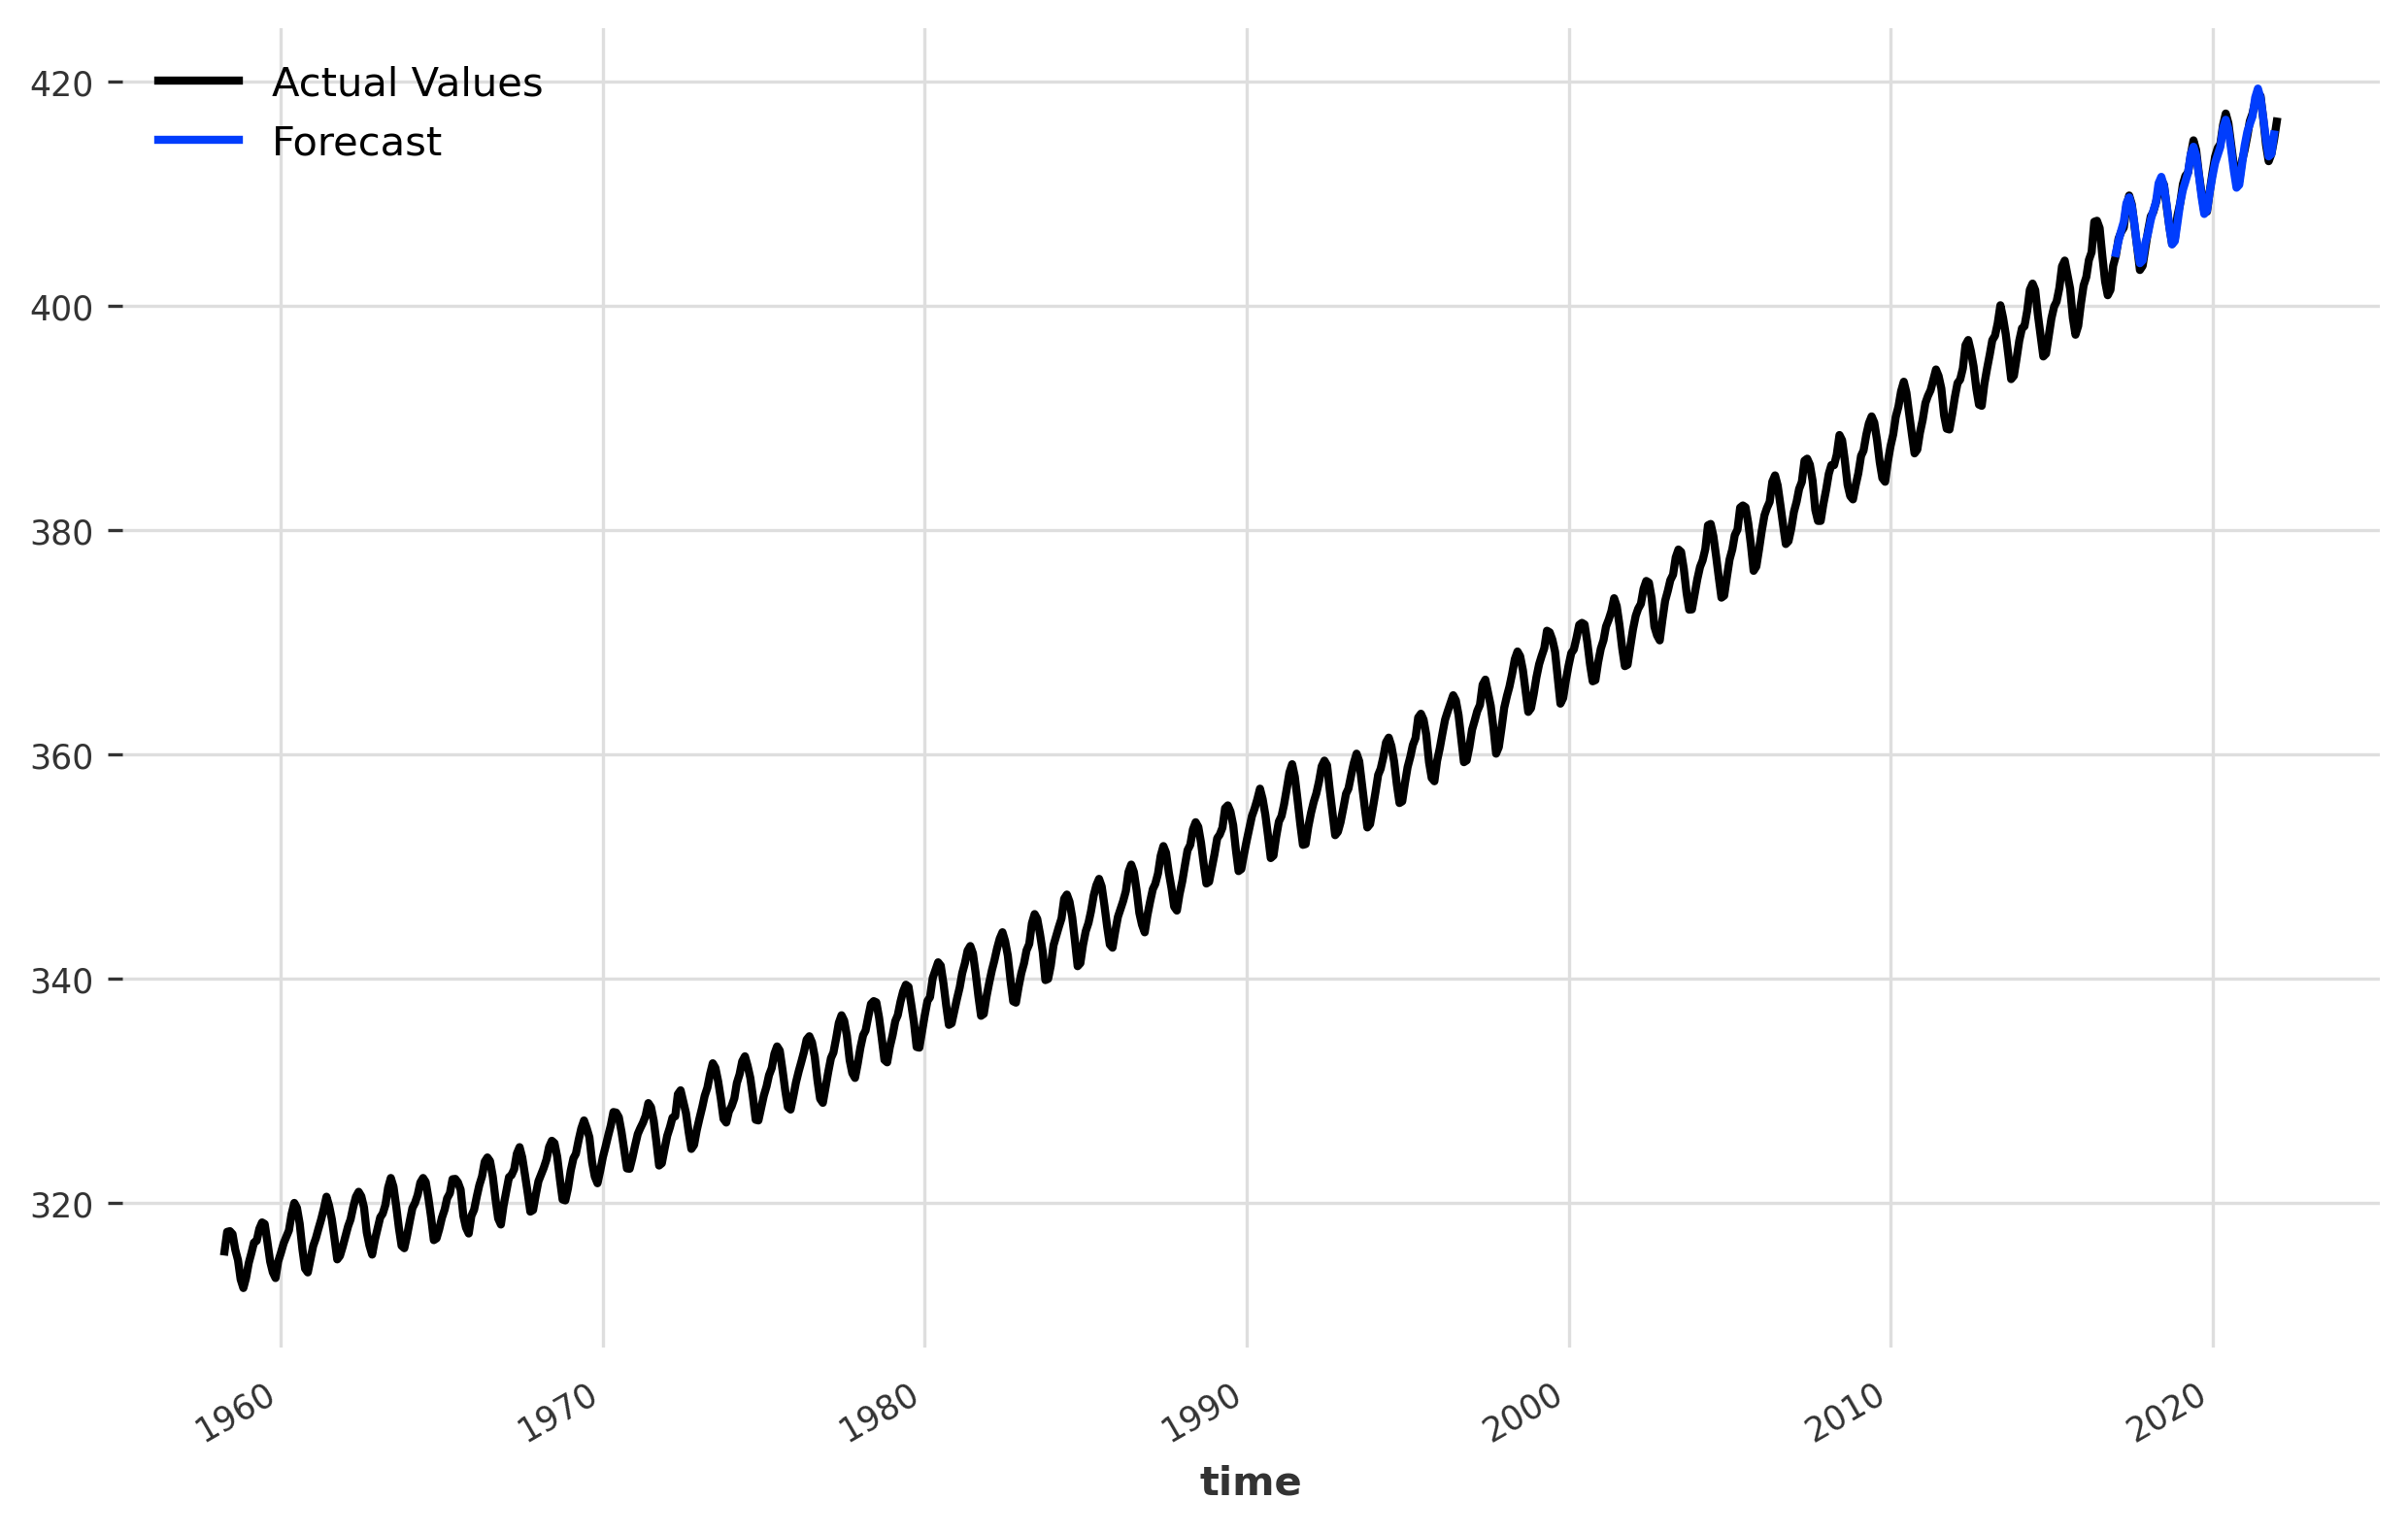

,SMAPE,MAE,RMSE
0,0.07,0.3,0.36


In [66]:
model = ExponentialSmoothing()

plt.figure(figsize = (10, 6))

forecast = backtest(series, model, start)
plot_backtest(series, forecast)
df = print_metrics(series, forecast)

plt.show()
df

### Creating a Linear Regression Forecasting Model

  0%|          | 0/5 [00:00<?, ?it/s]

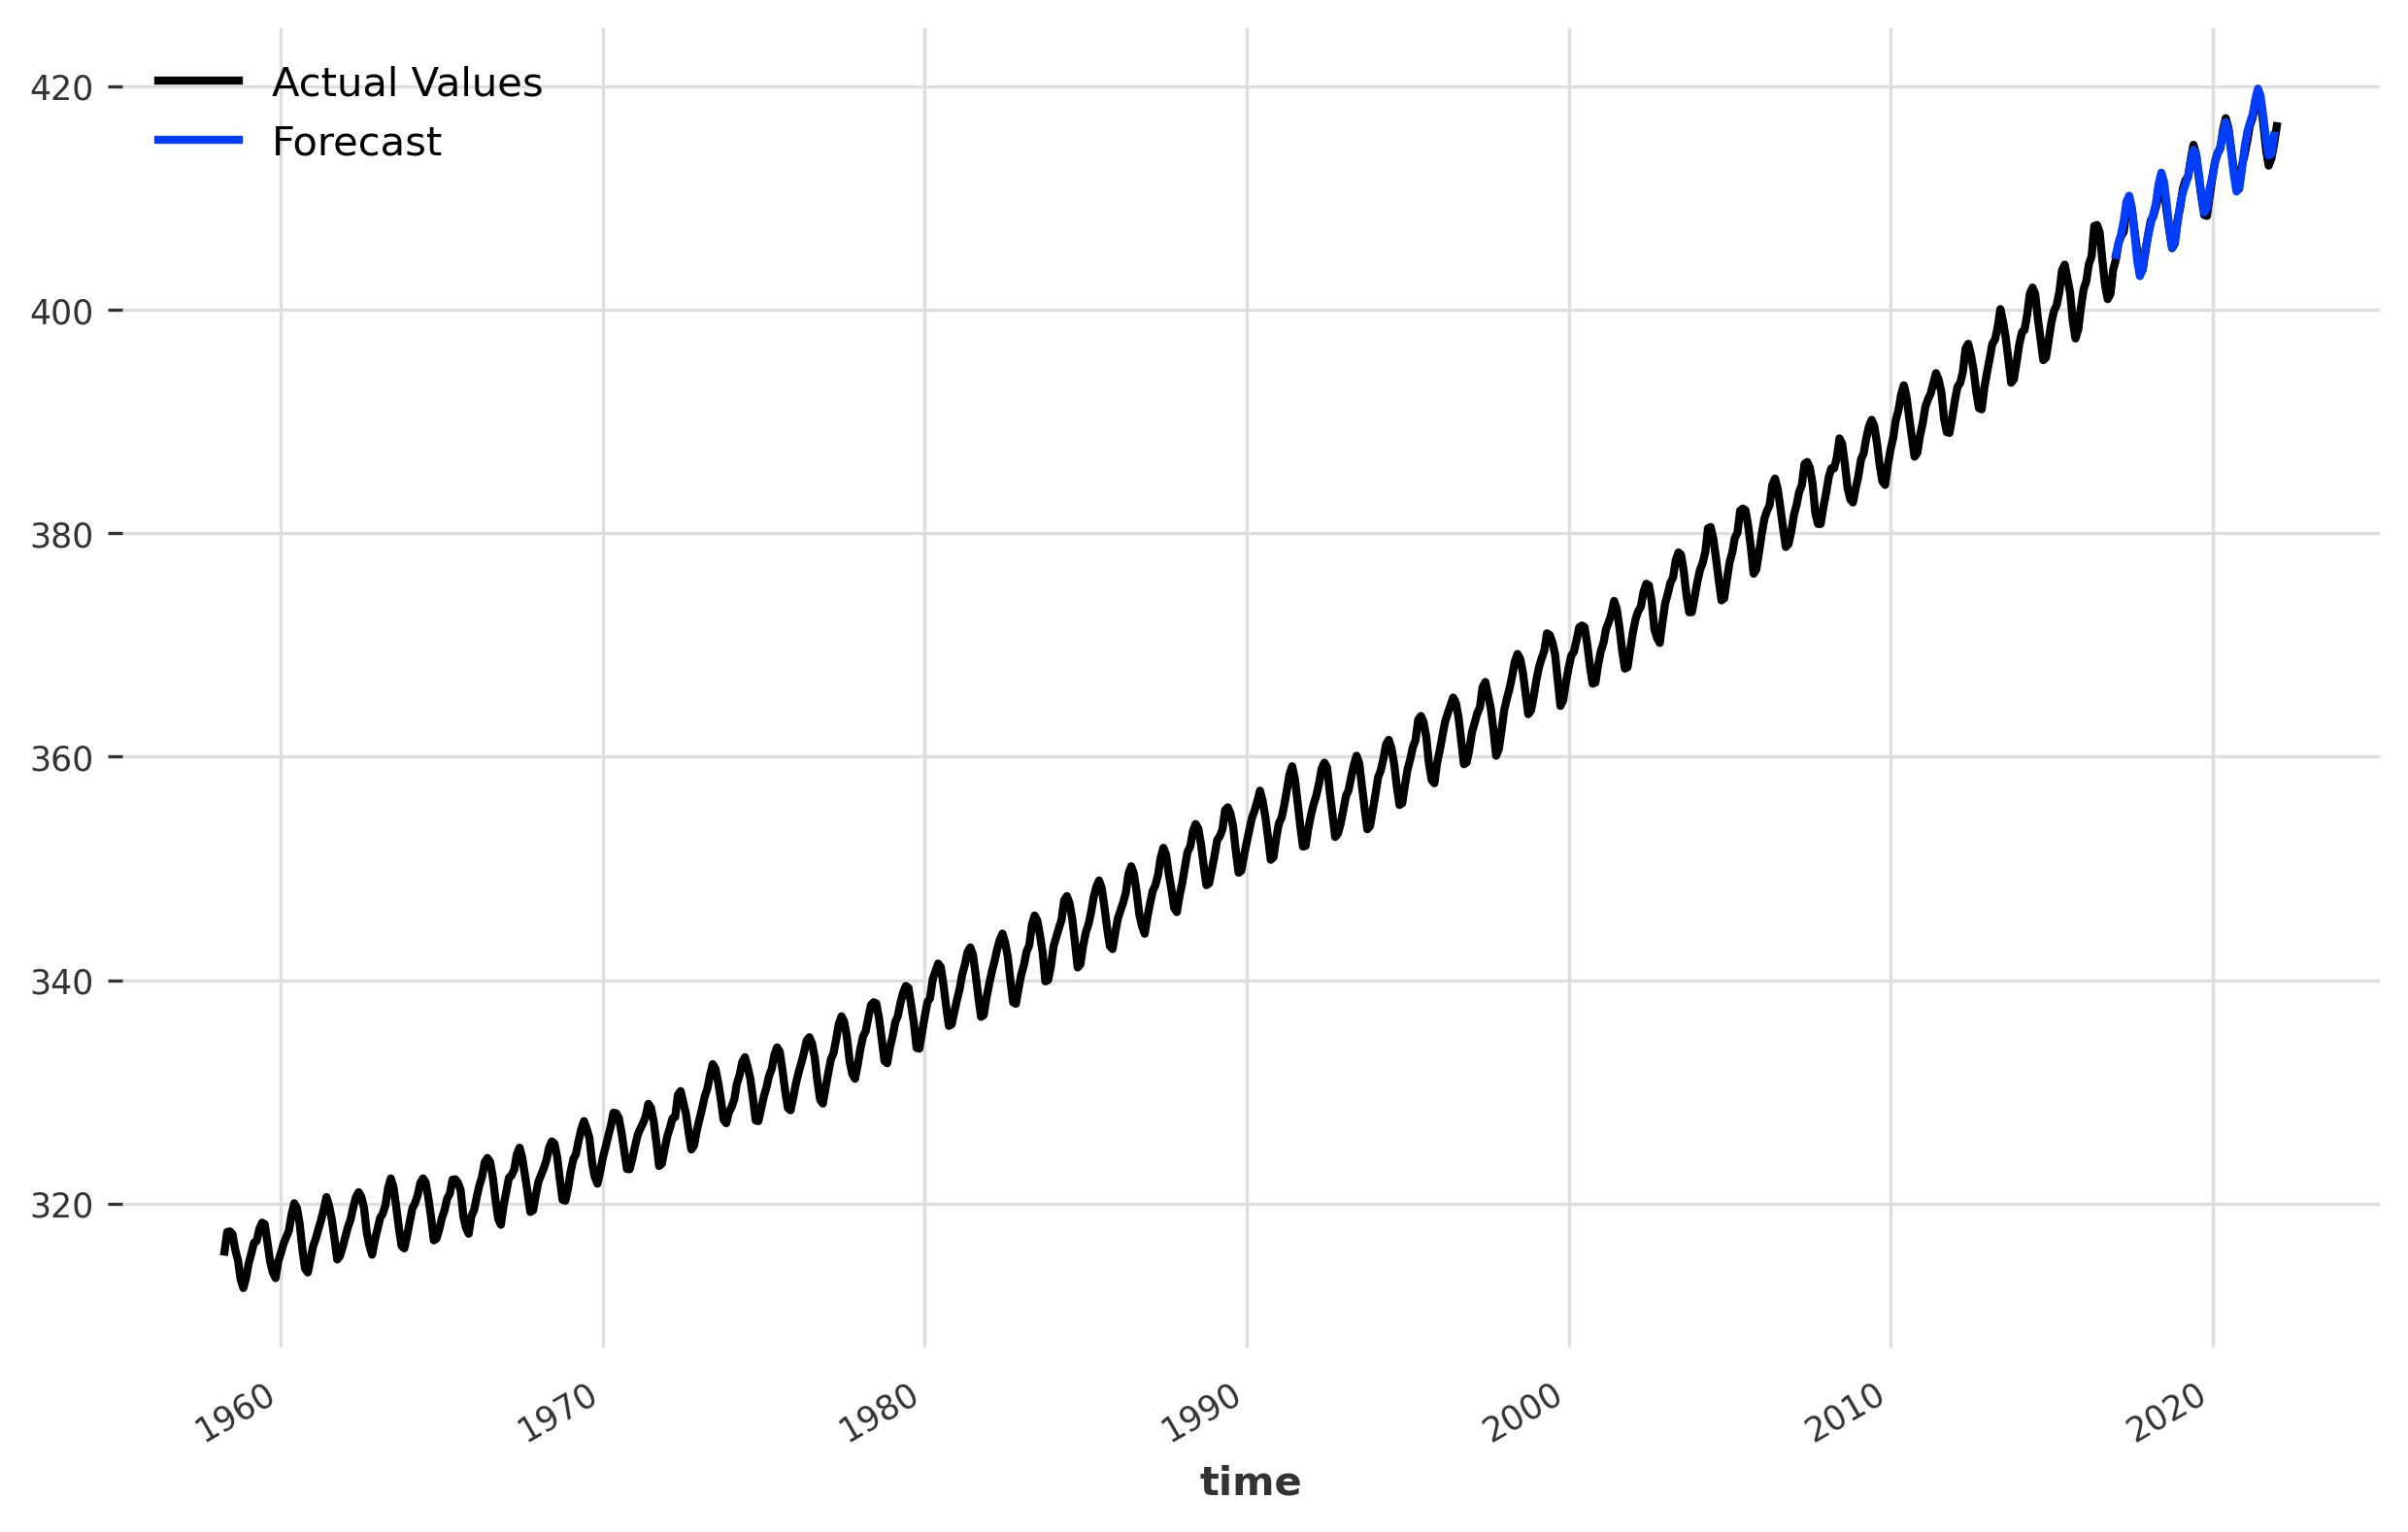

,SMAPE,MAE,RMSE
0,0.1,0.4,0.49


In [69]:
model = LinearRegressionModel(lags = 24)

plt.figure(figsize = (10, 6))

forecast = backtest(series, model, start)
plot_backtest(series, forecast)
df = print_metrics(series, forecast)

plt.show()
df

0.08737846582984551


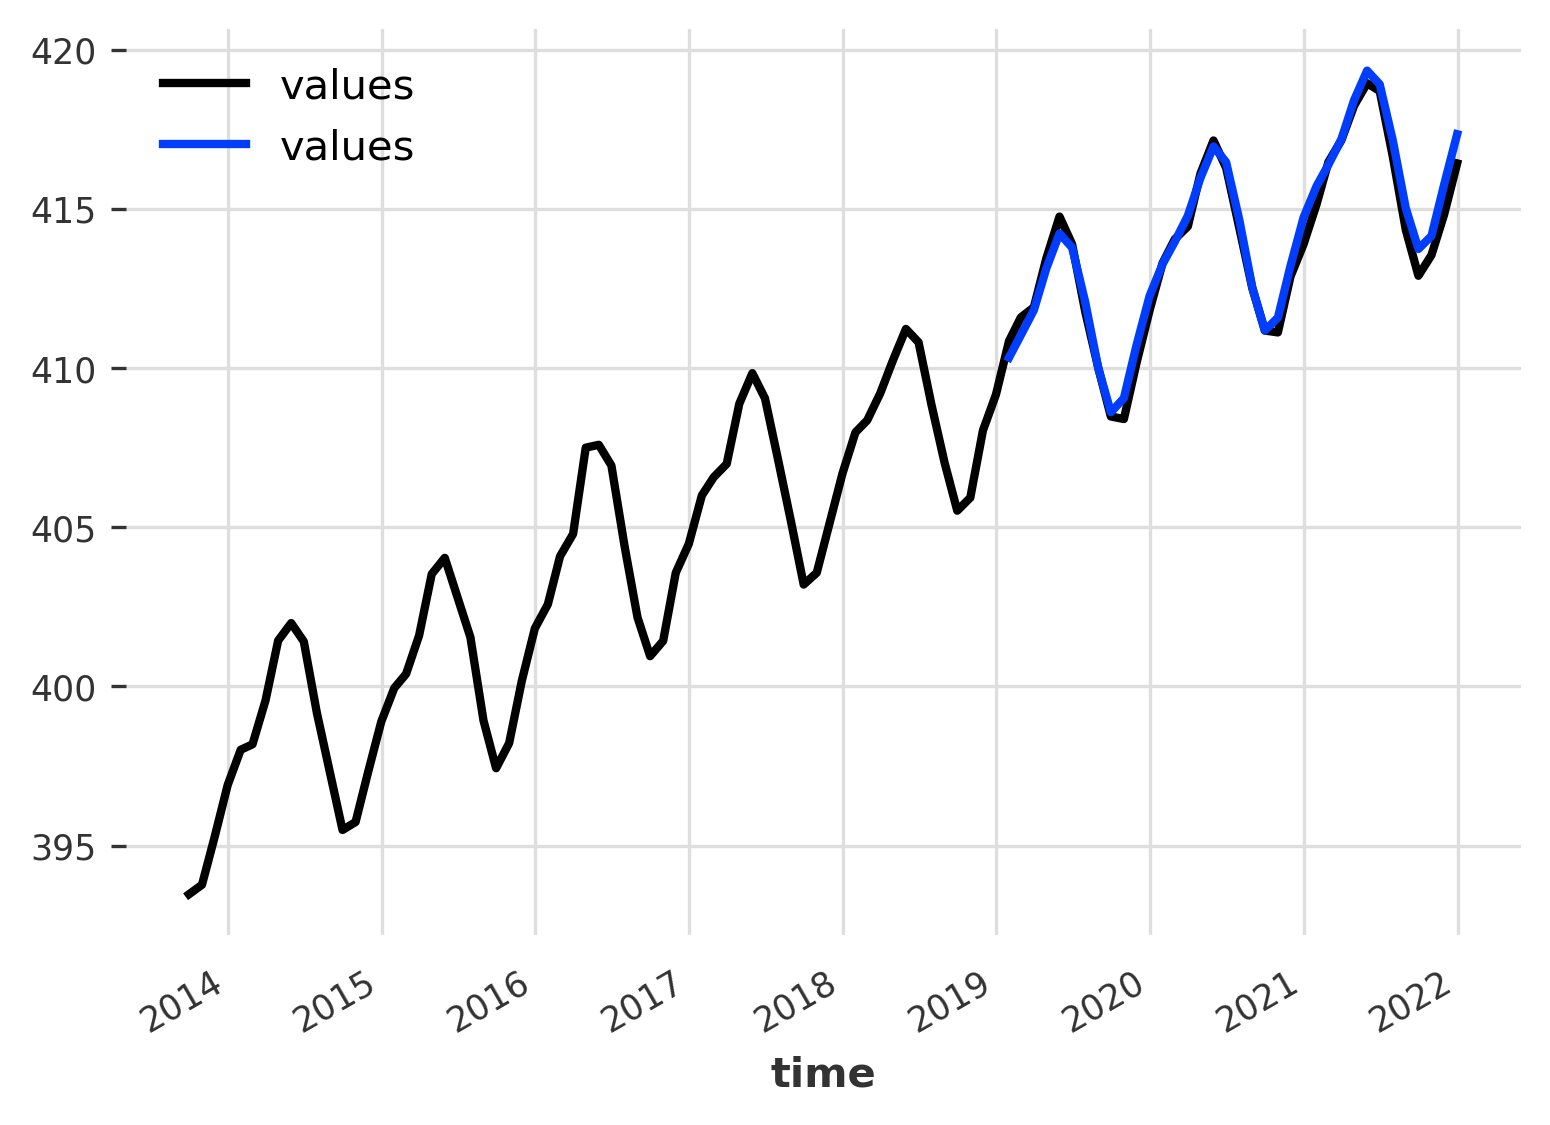

In [13]:
idx = -100

model = LinearRegressionModel(lags = 24)
#model = Prophet()
#model = ExponentialSmoothing()

train, val = series.split_before(730)
model.fit(train)
pred = model.predict(36)

series[idx:].plot()
pred[idx:].plot()


print(smape(val,pred))